<a href="https://colab.research.google.com/github/pavankonam/Computer-Vision/blob/main/pawan_ml_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import keras
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/train.zip

Archive:  /content/drive/MyDrive/train.zip
   creating: train/plant/
  inflating: train/plant/1012819099_23af2ed770.jpg  
  inflating: train/plant/1020396141_5bcbf82cd8.jpg  
  inflating: train/plant/1034621070_66661acec8.jpg  
  inflating: train/plant/1053052630_fdc5c718d3.jpg  
  inflating: train/plant/1087924982_6ac30661f3.jpg  
  inflating: train/plant/1098868739_858e14e009.jpg  
  inflating: train/plant/1110409179_a988627dbd.jpg  
  inflating: train/plant/1113351567_5922df2da6.jpg  
  inflating: train/plant/1126669133_b8cf20db09.jpg  
  inflating: train/plant/1142290661_1bc3da50db.jpg  
  inflating: train/plant/119146947_4c431fa7e0.jpg  
  inflating: train/plant/120021042_22200fa5b7.jpg  
  inflating: train/plant/120021118_9a4e8aec78.jpg  
  inflating: train/plant/1207386465_1ac7edb230.jpg  
  inflating: train/plant/1217154904_5bf755ec75.jpg  
  inflating: train/plant/1236251786_b01436e79c.jpg  
  inflating: train/plant/123704730_9160935fc3.jpg  
  inflating: train/plant/128077738

In [5]:
def image_gen_w_aug(train_parent_directory):
    
    train_datagen = ImageDataGenerator(rescale=1/255,
                                      rotation_range = 30,  
                                      zoom_range = 0.2, 
                                      width_shift_range=0.1,  
                                      height_shift_range=0.1,
                                      validation_split = 0.15)
    
  
    
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                                       target_size = (75,75),
                                                       batch_size = 40,
                                                       class_mode = 'categorical',
                                                       subset='training')
    
    val_generator = train_datagen.flow_from_directory(train_parent_directory,
                                                          target_size = (75,75),
                                                          batch_size = 7,
                                                          class_mode = 'categorical',
                                                          subset = 'validation')
    
    test_generator = test_datagen.flow_from_directory(train_parent_directory,
                                                     target_size=(75,75),
                                                     batch_size = 7,
                                                     class_mode = 'categorical')
    
    return train_generator, val_generator, test_generator


In [6]:
train_dir = os.path.join('/content/train')

In [7]:
train_generator, validation_generator, test_generator = image_gen_w_aug(train_dir)

Found 347 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


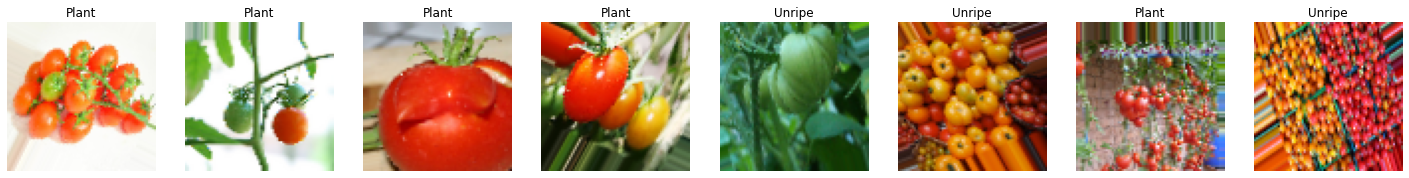

In [8]:
import numpy as np

CLASS_NAMES = np.array(['plant','unripe'], dtype='<U10')

import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(25,20))
  for n in range(8):
      ax = plt.subplot(1,8,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
      
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

In [9]:
pre_trained_model = InceptionV3(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [10]:
def model_output_for_TL (pre_trained_model, last_output):

    x = Flatten()(last_output)
    
    # Dense hidden layer
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    # Output neuron. 
    x = Dense(2, activation='softmax')(x)
    
    model = Model(pre_trained_model.input, x)
    
    return model

In [11]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed3')
last_output = last_layer.output

model_TL = model_output_for_TL(pre_trained_model, last_output)
model_TL.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model_TL.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[0][0]']

In [13]:
history_TL = model_TL.fit(
      train_generator,
      steps_per_epoch=5,  
      epochs=100,
      verbose=1,
      validation_data = validation_generator)

Epoch 1/100
5/5 [==============================] - 6s 819ms/step - loss: 15.6413 - accuracy: 0.4920 - val_loss: 6.0690 - val_accuracy: 0.5000
Epoch 2/100
5/5 [==============================] - 3s 688ms/step - loss: 7.6426 - accuracy: 0.4545 - val_loss: 7.2619 - val_accuracy: 0.5000
Epoch 3/100
5/5 [==============================] - 3s 651ms/step - loss: 3.4455 - accuracy: 0.5775 - val_loss: 2.1766 - val_accuracy: 0.5667
Epoch 4/100
5/5 [==============================] - 3s 691ms/step - loss: 2.1314 - accuracy: 0.6043 - val_loss: 1.6262 - val_accuracy: 0.6167
Epoch 5/100
5/5 [==============================] - 3s 680ms/step - loss: 1.5823 - accuracy: 0.6400 - val_loss: 1.8174 - val_accuracy: 0.6167
Epoch 6/100
5/5 [==============================] - 3s 700ms/step - loss: 0.8732 - accuracy: 0.7540 - val_loss: 0.9248 - val_accuracy: 0.7167
Epoch 7/100
5/5 [==============================] - 3s 671ms/step - loss: 0.8889 - accuracy: 0.7350 - val_loss: 1.0949 - val_accuracy: 0.6500
Epoch 8/100


In [14]:
tf.keras.models.save_model(model_TL,'rps_model.hdf5')

,loss,accuracy,val_loss,val_accuracy
0,15.641305,0.491979,6.068959,0.500000
1,7.642551,0.454545,7.261902,0.500000
2,3.445509,0.577540,2.176586,0.566667
3,2.131367,0.604278,1.626185,0.616667
4,1.582288,0.640000,1.817428,0.616667
...,...,...,...,...
95,0.157086,0.946524,0.659043,0.733333
96,0.233956,0.914438,0.644636,0.733333
97,0.203746,0.910000,0.686904,0.733333
98,0.152510,0.945000,0.584049,0.733333


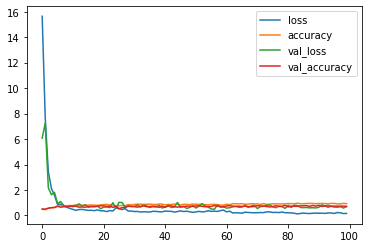

In [15]:
#Graphing
import pandas as pd
loss = pd.DataFrame(model_TL.history.history)
loss.plot()
loss

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


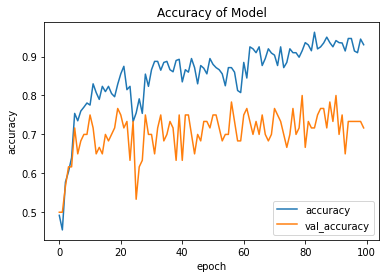

In [16]:
#Accuracy
import matplotlib.pyplot as plt
print(history_TL.history.keys())
plt.plot(history_TL.history['accuracy'])
plt.plot(history_TL.history['val_accuracy'])
plt.title('Accuracy of Model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc = 'lower right')
plt.show()

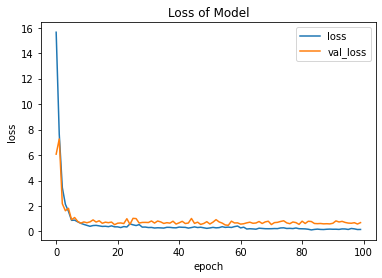

In [17]:
#Loss
plt.plot(history_TL.history['loss'])
plt.plot(history_TL.history['val_loss'])
plt.title('Loss of Model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'], loc = 'upper right')
plt.show()

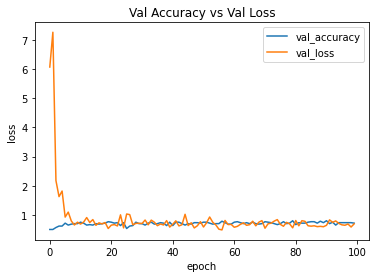

In [18]:
#Val accuracy vs Val Loss
plt.plot(history_TL.history['val_accuracy'])
plt.plot(history_TL.history['val_loss'])
plt.title('Val Accuracy vs Val Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['val_accuracy', 'val_loss'], loc = 'upper right')
plt.show()

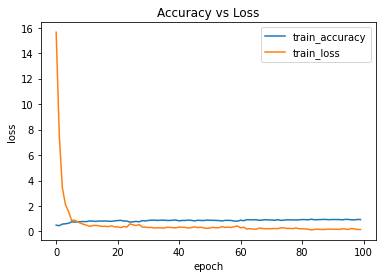

In [19]:
#Train accuracy vs Train Loss
plt.plot(history_TL.history['accuracy'])
plt.plot(history_TL.history['loss'])
plt.title('Accuracy vs Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_accuracy', 'train_loss'], loc = 'upper right')
plt.show()

 Please enter a url : /content/train/plant/1012819099_23af2ed770.jpg
The predicted output is : [[0.12524135 0.8747586 ]]
It's unripe


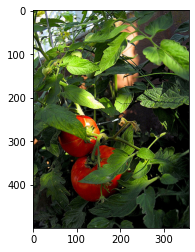

In [23]:
#Using PIL
import PIL
import numpy as np
from matplotlib import pyplot
from PIL import Image, ImageOps
size = (75,75)
rps = np.array([1, 2, 3], dtype = '<U10')
url = input(" Please enter a url : ")
picture = Image.open(url)
pyplot.imshow(picture)
picture = ImageOps.fit(picture, size, Image.ANTIALIAS)
picture = picture.convert('RGB')
picture = np.asarray(picture)
picture = (picture.astype(np.float32) / 255.0)
picture_reshape = picture[np.newaxis,...]
y_pred = model_TL.predict(picture_reshape)
#y_pred = rps[y_pred[0]]
print(f'The predicted output is : {y_pred}')
if np.argmax(y_pred) == 0:
  print("It's a Plant")
elif np.argmax(y_pred) == 1:
  print("It's unripe")


In [ ]:
!pip install streamlit -q

     |████████████████████████████████| 9.1 MB 34.6 MB/s 
     |████████████████████████████████| 178 kB 84.3 MB/s 
     |████████████████████████████████| 111 kB 72.0 MB/s 
     |████████████████████████████████| 180 kB 68.4 MB/s 
     |████████████████████████████████| 76 kB 5.4 MB/s 
     |████████████████████████████████| 4.3 MB 53.7 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 126 kB 65.8 MB/s 
     |████████████████████████████████| 791 kB 52.7 MB/s 
     |████████████████████████████████| 374 kB 77.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.23 which is incompatible.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.6.0 which is incompatible.
google-colab 1.0.0 requires ipyth

In [ ]:
%%writefile app.py
import numpy as np
import streamlit as st
import tensorflow as tf
from PIL import Image, ImageOps

def import_and_predict(image_data, model):
    
        size = (75,75)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = image.convert('RGB')
        image = np.asarray(image)
        image = (image.astype(np.float32) / 255.0)

        img_reshape = image[np.newaxis,...]

        prediction = model.predict(img_reshape)
        
        return prediction

model = tf.keras.models.load_model('rps_model.hdf5')

st.write("""
         # Ripe and Unripe Tomato Classifier
         """
         )

st.write("This is a simple image classification web app to predict whether a tomato is ripe or unripe")

file = st.file_uploader("Please upload an image file", type=["jpg", "png"])
#
if file is None:
    st.text("You haven't uploaded an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    prediction = import_and_predict(image, model)
    
    if np.argmax(prediction) == 0:
        st.write("It is Ripe!")
    elif np.argmax(prediction) == 1:
        st.write("It is Unripe!")
   
    
    st.text("Probability (0: Plant, 1: Unripe)")
    st.write(prediction)

Overwriting app.py


In [ ]:
!pip install pyngrok==4.1.1 --quiet

In [ ]:
from pyngrok import ngrok

In [ ]:
!nohup streamlit run app.py &
url=ngrok.connect(port='8501')
url

nohup: appending output to 'nohup.out'


'http://54aa-35-245-178-71.ngrok.io'